<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/main/Allen_Cahn_2%2B1_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda:0

--- One-stage joint training for 40000 iterations ---
Iter 0, total=5.132020e-01, ic=5.132020e-01, pde=5.144072e-03, lambda_pde=0.000
Iter 1000, total=4.190581e-01, ic=4.153616e-01, pde=1.848233e-02, lambda_pde=0.200
Iter 2000, total=2.625216e-01, ic=2.437579e-01, pde=4.690934e-02, lambda_pde=0.400
Iter 3000, total=1.415263e-01, ic=1.145808e-01, pde=4.490927e-02, lambda_pde=0.600
Iter 4000, total=5.916665e-02, ic=3.138044e-02, pde=3.473277e-02, lambda_pde=0.800
Iter 5000, total=4.119635e-02, ic=1.509867e-02, pde=2.609768e-02, lambda_pde=1.000
Iter 6000, total=3.235745e-02, ic=8.368741e-03, pde=2.398871e-02, lambda_pde=1.000
Iter 7000, total=3.134700e-02, ic=8.013532e-03, pde=2.333347e-02, lambda_pde=1.000
Iter 8000, total=2.864446e-02, ic=6.905691e-03, pde=2.173877e-02, lambda_pde=1.000
Iter 9000, total=2.637776e-02, ic=5.185235e-03, pde=2.119252e-02, lambda_pde=1.000
Iter 10000, total=2.687666e-02, ic=5.710437e-03, pde=2.116622e-02, lambda_pde=1.000
Iter 11000, t

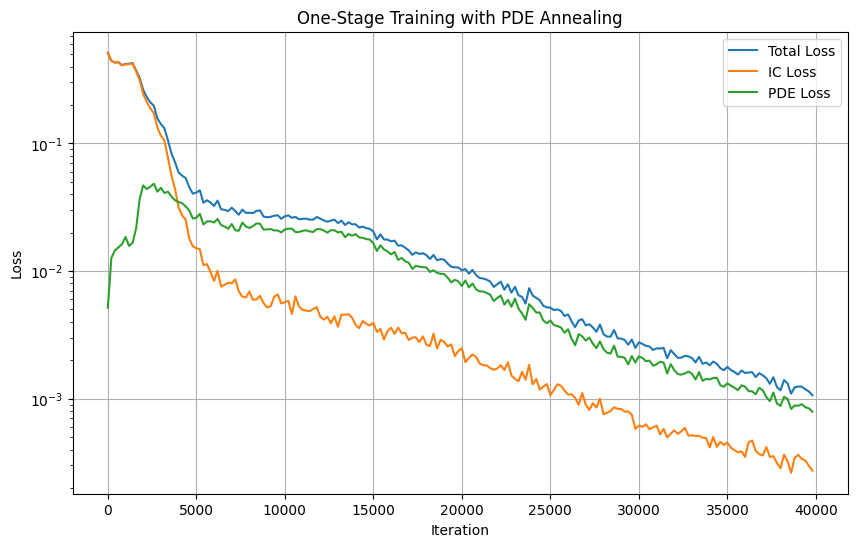


Plotting evaluation...


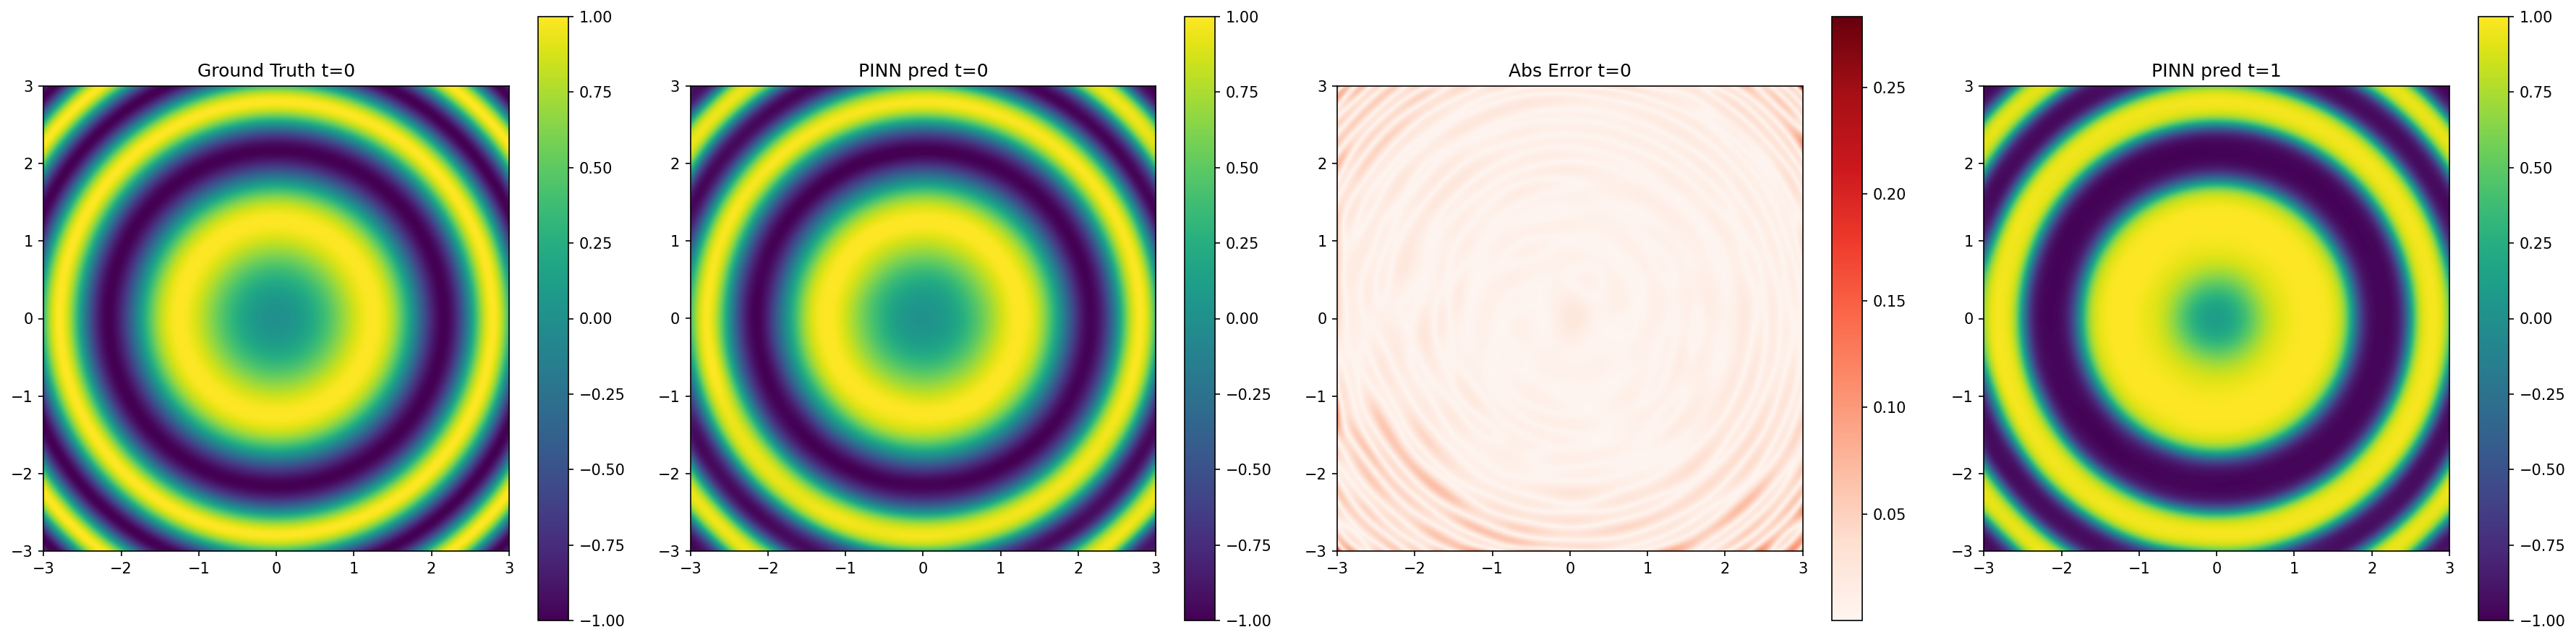


Plotting time evolution...


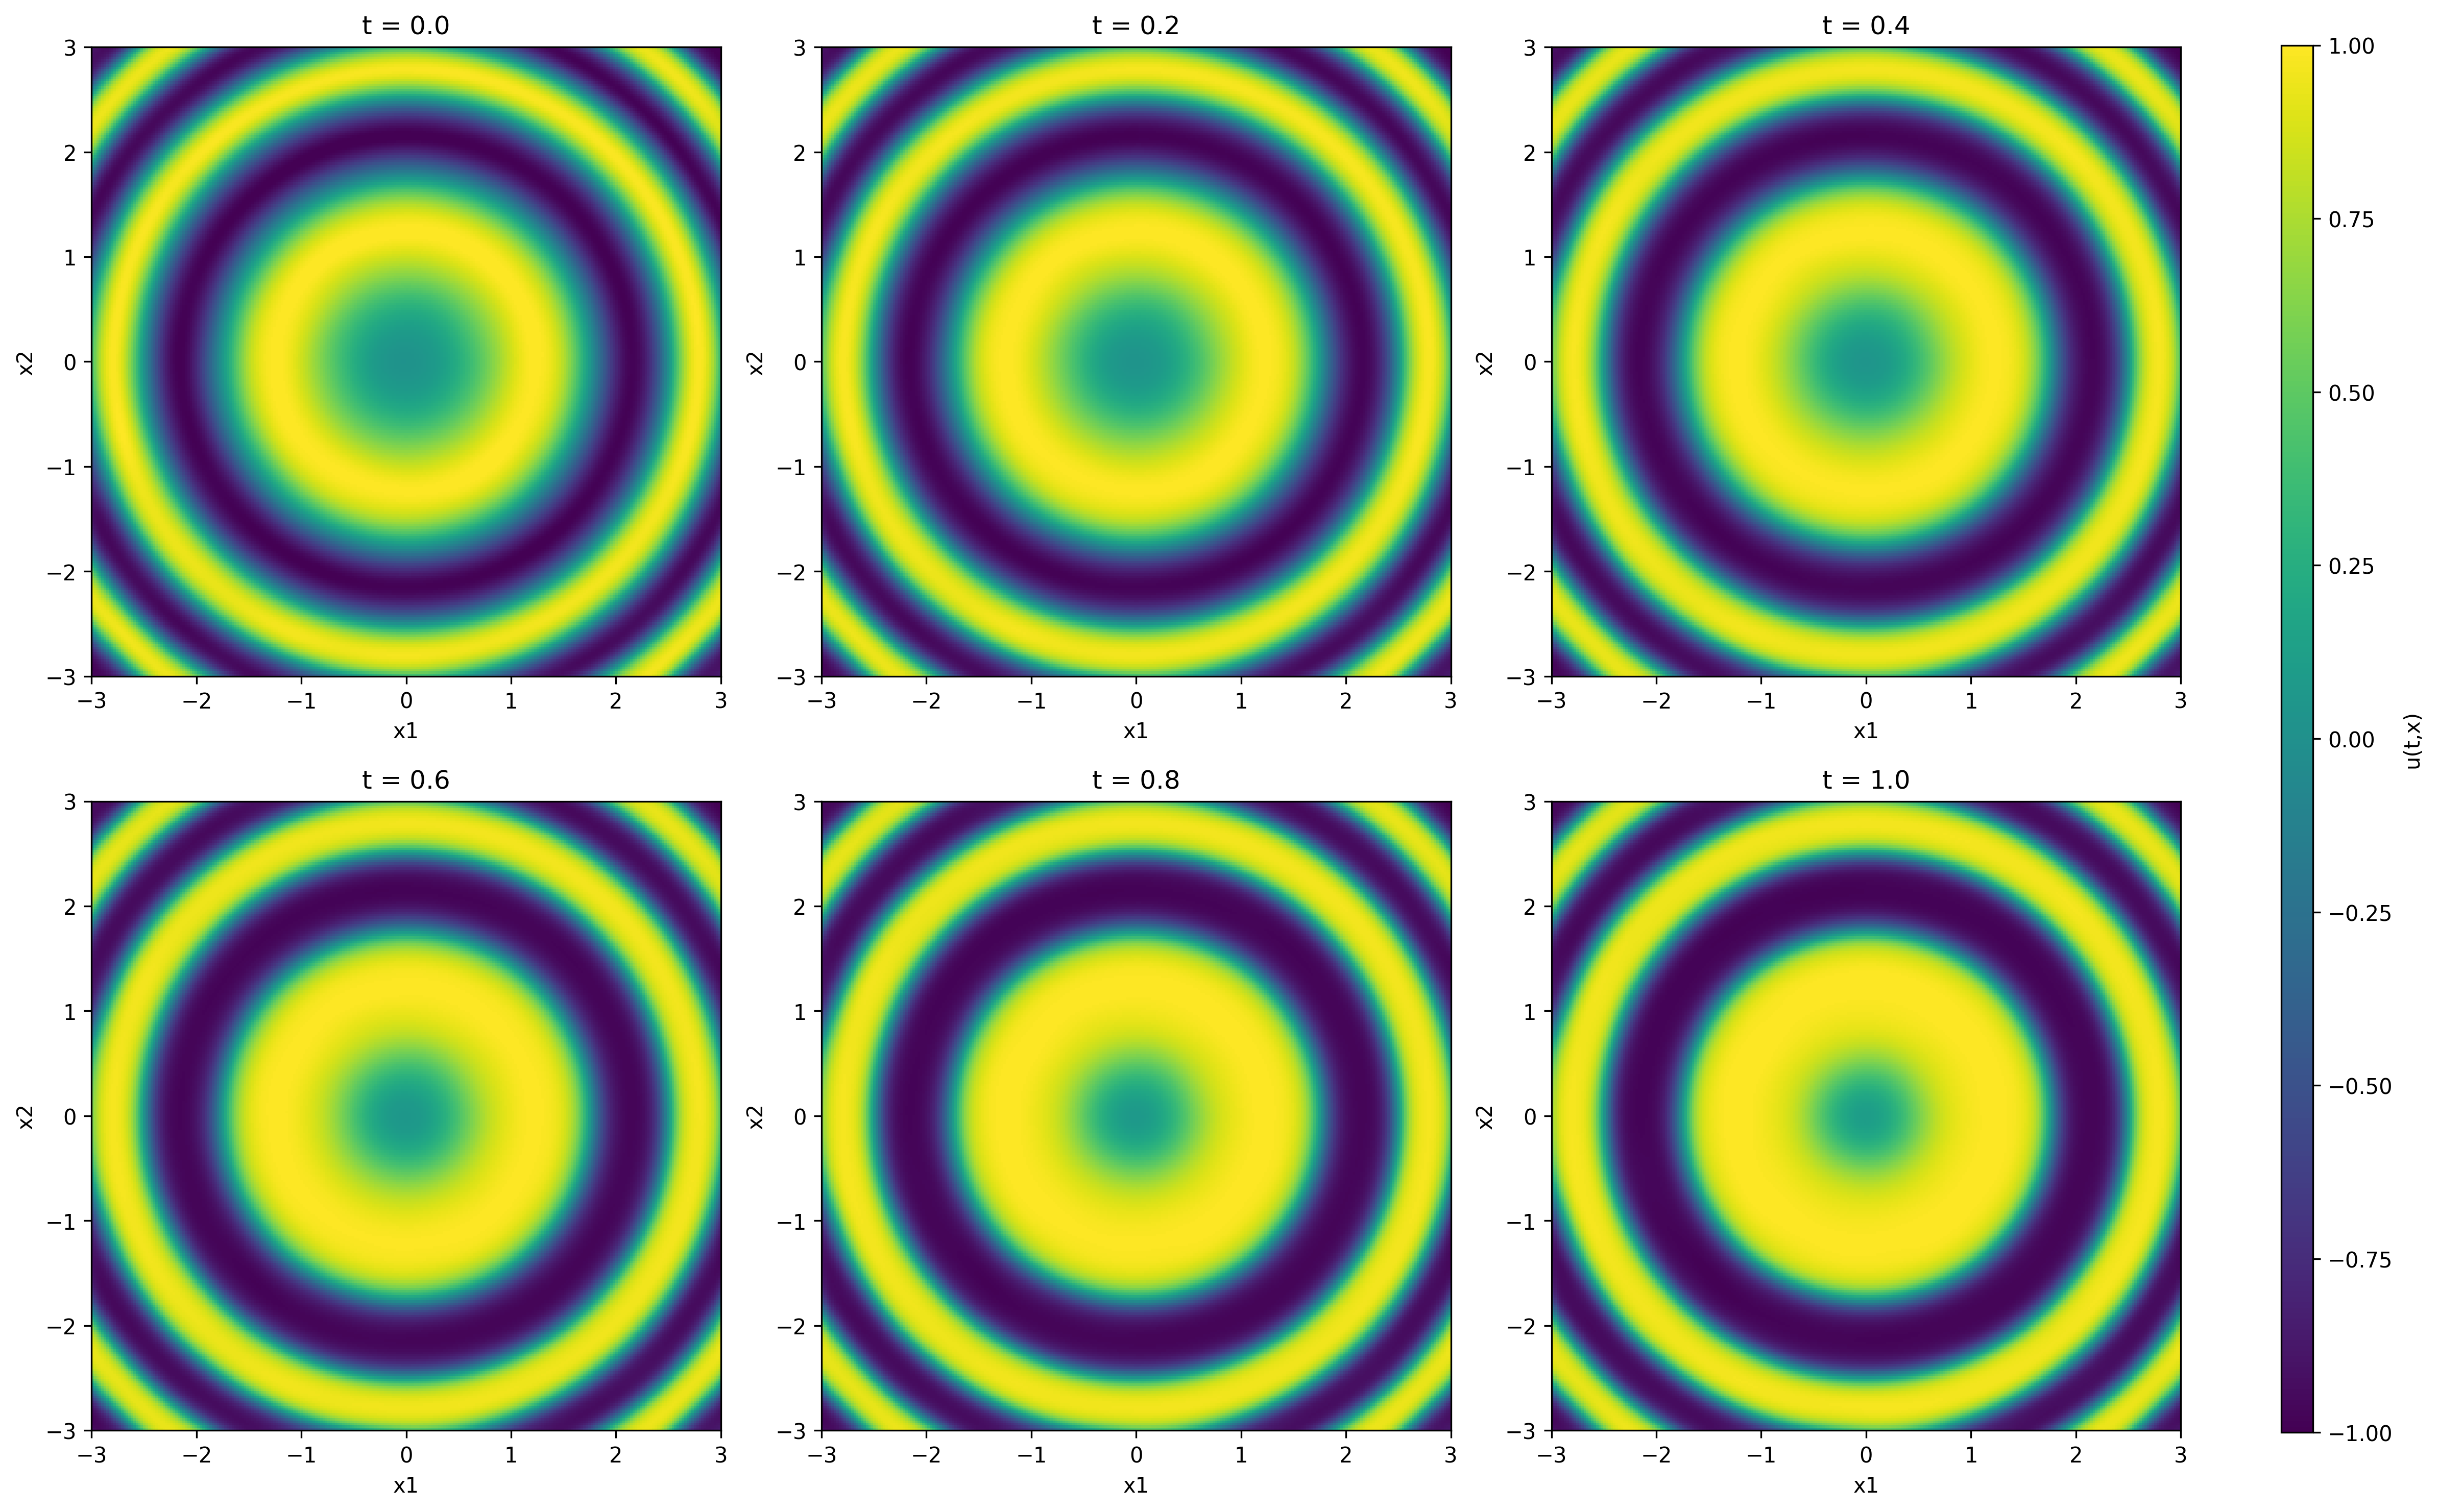

In [ ]:
# --- Imports ---
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import grad
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import time
import random

# --- Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# --- Device ---
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dev}")

# --- Custom sine activation ---
class Sine(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

# --- Parameters ---
T = 1.0
M_pde = 40000
M_ic = 10000

# --- Data ---
x_pde_train = (torch.rand(M_pde, 2, device=dev) * 6) - 3
t_pde_train = torch.rand(M_pde, 1, device=dev) * T
x_ic_train = (torch.rand(M_ic, 2, device=dev) * 6) - 3

# --- IC function ---
def phi(x):
    return torch.sin(torch.sum(x**2, dim=1, keepdim=True))

# --- Network ---
hidden = 256
N = torch.nn.Sequential(
    torch.nn.Linear(3, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, 1)
).to(dev)

# --- Optimizer ---
optimizer = torch.optim.Adam(N.parameters(), lr=1e-4)

# --- Hyperparameters ---
J_pde = 1024
J_ic = 1024
k_total = 40000
pde_anneal_steps = 5000.0  # where PDE loss ramps up

# --- One-stage joint training with annealing ---
print(f"\n--- One-stage joint training for {k_total} iterations ---")
total_loss_history = []
ic_loss_history = []
pde_loss_history = []

start_time = time.time()
for i in range(k_total):
    optimizer.zero_grad()

    # annealing ramp-up for PDE weight
    lambda_pde = min(1.0, i / pde_anneal_steps)
    lambda_ic = 1.0

    # IC batch
    idx_ic = torch.randint(0, M_ic, (J_ic,))
    x_ic = x_ic_train[idx_ic]
    t_ic = torch.zeros_like(x_ic[:, :1])
    u0_pred = N(torch.hstack((t_ic, x_ic)))
    ic_loss = (u0_pred - phi(x_ic)).square().mean()

    # PDE batch
    idx_pde = torch.randint(0, M_pde, (J_pde,))
    x_c = x_pde_train[idx_pde]
    t_c = t_pde_train[idx_pde]
    x1_c, x2_c = x_c[:,0:1], x_c[:,1:2]
    x1_c.requires_grad_()
    x2_c.requires_grad_()
    t_c.requires_grad_()

    u = N(torch.hstack((t_c, x1_c, x2_c)))
    u_t = grad(u, t_c, torch.ones_like(u), create_graph=True)[0]
    u_x1 = grad(u, x1_c, torch.ones_like(u), create_graph=True)[0]
    u_x2 = grad(u, x2_c, torch.ones_like(u), create_graph=True)[0]
    u_x1x1 = grad(u_x1, x1_c, torch.ones_like(u_x1), create_graph=True)[0]
    u_x2x2 = grad(u_x2, x2_c, torch.ones_like(u_x2), create_graph=True)[0]
    pde_res = u_t - (0.005*(u_x1x1 + u_x2x2) + u - u**3)
    pde_loss = pde_res.square().mean()

    # combine
    total_loss = lambda_ic * ic_loss + lambda_pde * pde_loss

    total_loss.backward()
    optimizer.step()

    if i % 200 == 0:
        total_loss_history.append(total_loss.item())
        ic_loss_history.append(ic_loss.item())
        pde_loss_history.append(pde_loss.item())
        if i % 1000 == 0:
            print(f"Iter {i}, total={total_loss.item():.6e}, ic={ic_loss.item():.6e}, pde={pde_loss.item():.6e}, lambda_pde={lambda_pde:.3f}")

print(f"Training finished in {time.time()-start_time:.2f} seconds.")

# --- Plotting ---
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(total_loss_history))*200, total_loss_history, label="Total Loss")
plt.plot(np.arange(len(ic_loss_history))*200, ic_loss_history, label="IC Loss")
plt.plot(np.arange(len(pde_loss_history))*200, pde_loss_history, label="PDE Loss")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("One-Stage Training with PDE Annealing")
plt.show()

# --- Evaluation
N.eval()
print("\nPlotting evaluation...")

mesh = 256
a,b = -3,3
xg, yg = torch.meshgrid(
    torch.linspace(a,b,mesh,device=dev),
    torch.linspace(a,b,mesh,device=dev),
    indexing="xy"
)
xy_flat = torch.cat((xg.reshape(-1,1), yg.reshape(-1,1)), dim=1)

z_true = phi(xy_flat).cpu().numpy().reshape(mesh,mesh)
with torch.no_grad():
    t_zero = torch.zeros_like(xy_flat[:, :1])
    u0_pred = N(torch.cat((t_zero,xy_flat), dim=1)).cpu().numpy().reshape(mesh,mesh)
    t_final = torch.ones_like(xy_flat[:, :1]) * T
    u1_pred = N(torch.cat((t_final,xy_flat), dim=1)).cpu().numpy().reshape(mesh,mesh)

fig, axs = plt.subplots(1,4,figsize=(24,6),dpi=150)

im0 = axs[0].imshow(z_true, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[0].set_title("Ground Truth t=0")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(u0_pred, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[1].set_title("PINN pred t=0")
plt.colorbar(im1, ax=axs[1])

err = np.abs(z_true - u0_pred)
im2 = axs[2].imshow(err, extent=[a,b,a,b], cmap="Reds")
axs[2].set_title("Abs Error t=0")
plt.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(u1_pred, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[3].set_title("PINN pred t=1")
plt.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()

# --- Time evolution
print("\nPlotting time evolution...")
time_steps = [0.0,0.2,0.4,0.6,0.8,1.0]
fig2 = plt.figure(figsize=(16,10), dpi=300)
gs = GridSpec(2,4,width_ratios=[1,1,1,0.05])

for idx, tval in enumerate(time_steps):
    with torch.no_grad():
        t_plot = torch.full((mesh**2,1), tval, device=dev)
        u_plot = N(torch.cat((t_plot, xy_flat), dim=1)).cpu().numpy().reshape(mesh,mesh)

    ax = fig2.add_subplot(gs[idx//3, idx%3])
    ax.set_title(f"t = {tval:.1f}")
    im = ax.imshow(u_plot, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

norm = Normalize(vmin=-1,vmax=1)
sm = ScalarMappable(norm=norm, cmap="viridis")
cax = fig2.add_subplot(gs[:,3])
fig2.colorbar(sm, cax=cax, orientation="vertical", label="u(t,x)")

plt.tight_layout()
plt.show()
